# Stochastic Gradient Descent (GD): Logistic Regression

In this example, we train a linear and a quadratic logistic regression classifier using data from 10, 100, and 1000 samples respectively. First, in each case, validation and training data are generated using 2D Gaussian Mixture Models (GMMs). Classifiers are then trained, with linear and quadratic trained weights generated using GD and stochastic GD algorithms. These weights are used afterwards to classify the validation data (10000 samples). 

Classification results for both the linear and quadratic classifiers are plotted over the 2D mixture data.

First import the necessary modules and configurations:

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
from matplotlib import cm

from math import ceil, floor 

import numpy as np
import seaborn as sns
from scipy.stats import norm, multivariate_normal

np.set_printoptions(suppress=True)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [2]:
# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

# Number of training input samples for experiments
N_train = [10, 100, 1000]
# Number of validation samples for experiments
N_valid = 10000

We'll also be generating data from GMM distributions, which are of the form:

$$ p(\mathbf{x}) = \sum_{k=1}^C a_k p_k(\mathbf{x}),$$

where $p_k(\mathbf{x}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k)$ for $k \in \{1, \ldots, C\}$, with each $k^{th}$ component distribution represented as a multivariate Gaussian, and $a_k$ is the $k^{th}$ mixture weight, such that both $0 \leq a_k \leq 1$ and $\sum_{k=1}^K a_k = 1$ are satisfied.

I'll define the follow data-generating utility function, as we'll be sampling from GMM distributions multiple times:

In [3]:
def generate_data_from_gmm(N, pdf_params, fig_ax=None):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['mu'].shape[1]
    # Determine number of classes/mixture components
    C = len(pdf_params['priors'])

    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    marker_shapes = 'ox+*.' # Accomodates up to C=5
    marker_colors = 'brgmy'
    Y = np.array(range(1, C+1))
    for y in Y:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[y-1] <= u) & (u <= thresholds[y]))[:, 0]
        # No. of samples in this component
        Ny = len(indices)  
        labels[indices] = y * np.ones(Ny) - 1
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['mu'][y-1], pdf_params['Sigma'][y-1], Ny)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['mu'][y-1], pdf_params['Sigma'][y-1], Ny)
                
    if fig_ax and (0 < n <= 3):
        if n == 1:
            fig_ax.scatter(X, np.zeros(N), c=labels)
        elif n == 2:
            fig_ax.scatter(X[:, 0], X[:, 1], c=labels)
            fig_ax.set_ylabel("y-axis")
            fig_ax.set_aspect('equal')
        else:
            fig_ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels)
            fig_ax.set_ylabel("y-axis")
            fig_ax.set_zlabel("z-axis")
            fig_ax.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))

        fig_ax.set_xlabel("x-axis")

    
    return X, labels

## Dataset Setting

Assume our class priors are $P(Y=0)=0.9$ and $P(Y=1)=0.1$ ($a_0 = 0.9$ and $a_1 = 0.1$). We will consider the following parameters for our GMM of two bivariate Gaussian class-conditionals:

\begin{equation*}
    \mathbf{\mu}_0=\begin{bmatrix} -2\\2 \end{bmatrix} ~~~
    \mathbf{\Sigma}_0=\begin{bmatrix}2 & -0.9 \\-0.9 & 1 \end{bmatrix}, ~~~
    \mathbf{\mu}_1=\begin{bmatrix} -1\\1 \end{bmatrix} ~~~
    \mathbf{\Sigma}_1=\begin{bmatrix}2 & -0.9 \\-0.9 & 3 \end{bmatrix}. ~~~
\end{equation*}

Let's  generate the following independent datasets each consisting
of iid samples from the specified data distribution, and in each dataset make sure to include
the true class label for each sample:
*   $D_{train}^{10}$ consists of 10 samples and their labels for training;
*   $D_{train}^{100}$ consists of 100 samples and their labels for training;
*   $D_{train}^{1000}$ consists of 1000 samples and their labels for training.
*   $D_{valid}^{10K}$ consists of 10000 samples and their labels for validation;

The validation set is a disjoint set from our training data that is usually used for model/hyperparameter selection.

Generating the training data set; Ntrain = 10
Generating the training data set; Ntrain = 100
Generating the training data set; Ntrain = 1000
Label counts for training sets:  [array([9, 1]), array([92,  8]), array([906,  94])]
Label counts for validation set:  [8963 1037]


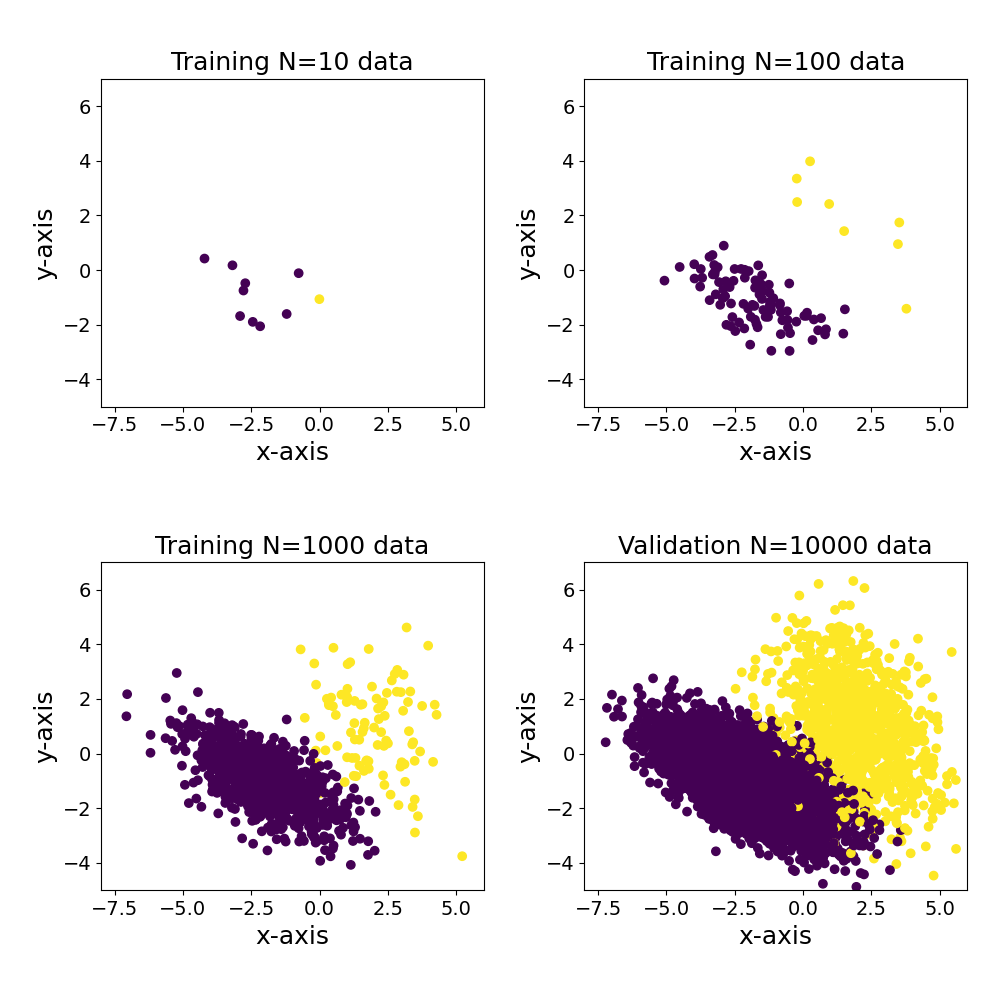

In [4]:
gmm_pdf = {}
# Likelihood of each distribution to be selected AND class priors!!!
gmm_pdf['priors'] = np.array([0.9, 0.1])  
gmm_pdf['mu'] = np.array([[-2, -1],
                          [2, 1]])  # Gaussian distributions means
gmm_pdf['Sigma'] = np.array([[[2, -0.9],
                              [-0.9, 1]],
                             [[2, -0.9],
                              [-0.9, 3]]])  # Gaussian distributions covariance matrices

# Create figure outside the generate GMM function, but populate axes within sampling function
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Lists to hold the corresponding input matrices, target vectors and sample label counts per training set
X_train = []
y_train = []
Ny_train = []

# Index for axes
t = 0
for N_t in N_train:
    print("Generating the training data set; Ntrain = {}".format(N_t))
    
    # Modulus to plot in right locations, hacking it
    X_t, y_t = generate_data_from_gmm(N_t, gmm_pdf, fig_ax=ax[floor(t/2), t%2])
    ax[floor(t/2), t%2].set_title("Training N={} data".format(N_t))
    t += 1

    # Prepend column of ones to create augmented inputs tilde{x}
    X_t = np.column_stack((np.ones(N_t), X_t))  
    n = X_t.shape[1]

    Ny_t = np.array((sum(y_t == 0), sum(y_t == 1)))
    
    # Add to lists
    X_train.append(X_t)
    y_train.append(y_t)
    Ny_train.append(Ny_t)

print("Label counts for training sets: ", Ny_train)

# Also generate validation dataset from GMM!
X_valid, y_valid = generate_data_from_gmm(N_valid, gmm_pdf, fig_ax=ax[1, 1])
# Prepend column of ones to create augmented inputs tilde{x}
X_valid = np.column_stack((np.ones(N_valid), X_valid))  
ax[1, 1].set_title("Validation N={} data".format(N_valid))
        
Ny_valid = np.array((sum(y_valid == 0), sum(y_valid == 1)))
print("Label counts for validation set: ", Ny_valid)

# Using validation set samples to limit axes (most samples drawn, highest odds of spanning sample space)
x1_valid_lim = (floor(np.min(X_valid[:,1])), ceil(np.max(X_valid[:,1])))
x2_valid_lim = (floor(np.min(X_valid[:,2])), ceil(np.max(X_valid[:,2])))
plt.setp(ax, xlim=x1_valid_lim, ylim=x2_valid_lim)
plt.tight_layout()
plt.show()

fig;

## Logistic Regression

Now let's train our logistic regression classifiers with mini-batch GD. First note that our binary logistic regression model is specified as:

\begin{align*}
P(y \, | \, \mathbf{x}; \boldsymbol{\theta}) & = \text{Ber}(y \, | \, g(\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}})) \\
 & = g(\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}})^y (1-g(\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}))^{(1-y)}
\end{align*}

where $\mathbf{\tilde{x}}^\intercal = \begin{bmatrix} 1 & x_1 & \ldots & x_n \end{bmatrix}$ is our augmented input vector to handle the bias term, $\theta_0$.

The prediction function for our model (outputting probabilities in logistic regression) can then be written as:

$$\hat{y} = g(\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}) = \frac{1}{1 + e^{-\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}}},$$

where $g(z)$ is the <b>sigmoid/logistic</b> function:

$$g(z) = \displaystyle \frac{1}{1 + e^{-z}} = \frac{e^z}{e^z + 1}. $$

The prediction function in matrix form for all $N$ examples is $\hat{\mathbf{y}} = g(\mathbf{X}\boldsymbol{\theta})$. In code, we can express this model simply as follows:

In [5]:
# Define the logistic/sigmoid function
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Define the prediction function y = 1 / (1 + np.exp(-X*theta))
# X.dot(theta) inputs to the sigmoid referred to as logits
def predict_prob(X, theta):
    logits = X.dot(theta)
    return sigmoid(logits)

### Mini-batch GD

Recall the mini-batch GD algorithm, but note the gradient update step is tailored to logistic regression:

1) Initialize $\boldsymbol{\theta}^{(0)}$

2) Batchify dataset: $\mathcal{B}_b \sim \text{Uniform}\{1, \ldots, N\}$

3) Repeat until convergence:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; For each $ b $ in total number of batches:
\begin{align*}
\boldsymbol{\theta}^{(t+1)} & = \boldsymbol{\theta}^{(t)} - \alpha \nabla \mathbb{E}_{i \in \mathcal{B}_b} [\mathcal{L}_i(\boldsymbol{\theta}^{(t)})] \\
& = \boldsymbol{\theta}^{(t)} - \alpha \Bigg(\frac{1}{|\mathcal{B}_b|}\sum_{i \in \mathcal{B}_b} \left[ \left( g(\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}^{(i)}) - y^{(i)} \right)\mathbf{\tilde{x}}^{(i)} \right] \Bigg)
\end{align*}

4) When $\mathbf{g}(\boldsymbol{\theta}) \approx \mathbf{0}$, then we have derived $\boldsymbol{\theta}_{SGD}$ using mini-batch GD

The algorithm is coded as follows:

In [6]:
# NOTE: This implementation may encounter numerical stability issues... 
# Read into the log-sum-exp trick OR use a method like: sklearn.linear_model import LogisticRegression
def log_reg_loss(theta, X, y):
    # Size of batch
    B = X.shape[0]

    # Logistic regression model g(X * theta)
    predictions = predict_prob(X, theta)

    # NLL loss, 1/N sum [y*log(g(X*theta)) + (1-y)*log(1-g(X*theta))]
    error = predictions - y
    nll = -np.mean(y*np.log(predictions) + (1 - y)*np.log(1 - predictions))
    
    # Partial derivative for GD
    g = (1 / B) * X.T.dot(error)
    
    # Logistic regression loss, NLL (binary cross entropy is another interpretation)
    return nll, g


# Options for mini-batch gradient descent
opts = {}
opts['max_epoch'] = 1000
opts['alpha'] = 1e-3
opts['tolerance'] = 1e-3

opts['batch_size'] = 10

# Breaks the matrix X and vector y into batches
def batchify(X, y, batch_size, N):
    X_batch = []
    y_batch = []

    # Iterate over N in batch_size steps, last batch may be < batch_size
    for i in range(0, N, batch_size):
        nxt = min(i + batch_size, N + 1)
        X_batch.append(X[i:nxt, :])
        y_batch.append(y[i:nxt])

    return X_batch, y_batch


def gradient_descent(loss_func, theta0, X, y, N, *args, **kwargs):
    # Mini-batch GD. Stochastic GD if batch_size=1.

    # Break up data into batches and work out gradient for each batch
    # Move parameters theta in that direction, scaled by the step size.

    # Options for total sweeps over data (max_epochs),
    # and parameters, like learning rate and threshold.

    # Default options
    max_epoch = kwargs['max_epoch'] if 'max_epoch' in kwargs else 200
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
    epsilon = kwargs['tolerance'] if 'tolerance' in kwargs else 1e-6

    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 10

    # Turn the data into batches
    X_batch, y_batch = batchify(X, y, batch_size, N)
    num_batches = len(y_batch)
    print("%d batches of size %d\n" % (num_batches, batch_size))

    theta = theta0
    m_t = np.zeros(theta.shape)

    trace = {}
    trace['loss'] = []
    trace['theta'] = []

    # Main loop:
    for epoch in range(1, max_epoch + 1):
        # print("epoch %d\n" % epoch)
        
        loss_epoch = 0
        for b in range(num_batches):
            X_b = X_batch[b]
            y_b = y_batch[b]
            # print("epoch %d batch %d\n" % (epoch, b))

            # Compute NLL loss and gradient of NLL function
            loss, gradient = loss_func(theta, X_b, y_b, *args)
            loss_epoch += loss
            
            # Steepest descent update
            theta = theta - alpha * gradient
            
            # Terminating Condition is based on how close we are to minimum (gradient = 0)
            if np.linalg.norm(gradient) < epsilon:
                print("Gradient Descent has converged after {} epochs".format(epoch))
                break
                
        # Storing the history of the parameters and loss values per epoch
        trace['loss'].append(np.mean(loss_epoch))
        trace['theta'].append(theta)
        
        # Also break epochs loop
        if np.linalg.norm(gradient) < epsilon:
            break

    return theta, trace

### Linear vs Quadratic 

Often we want to apply non-linear decision boundaries to our classification problem, but ensure that the prediction function/model, e.g. $g(\boldsymbol{\theta}^\intercal \mathbf{x})$, is still linear w.r.t. the parameters $\boldsymbol{\theta}$. The trick is to transform the input feature vector using a transformation $\phi(\mathbf{x})$ onto another feature space, where the data is still linear in that space. 

<u>Example:</u> Transform features $\phi(x_1, x_2) = [1, x_1^2, x_2^2]$ with $\boldsymbol{\theta}= [-R^2, 1, 1 ]$, such that the decision boundary $ \boldsymbol{\theta}^\intercal \phi({\mathbf{x}}) = x_1^2 + x_2^2 -R^2$ is a circle with radius $R$.

This general technique might often be regarded as feature engineering, data transformation, or basis expansion, and it can be applied to both regression and classification to result in a <b>polynomial</b> model. Note that hand-designing this $\phi(\mathbf{x})$ often requires domain knowledge, which we do not have, and so one of the main perks in neural networks is how they automatically learn the parameters of this <b>feature extractor</b> $\phi(\mathbf{x})$ in addition to the linear model parameters.

Below we explore this technique in the context of logistic regression, where we can express the basis expansion form as:

$$g(\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}) = \frac{1}{1 + e^{-\boldsymbol{\theta}^\intercal \phi(\mathbf{\tilde{x}})}}.$$

For a logistic-<b>linear</b>-model, we would expect the expansion $\phi(\mathbf{x}) = [1, x_1, \ldots, x_n]$ with $\boldsymbol{\theta}=[\theta_0, \theta_1, \ldots, \theta_n]$. Let's generalize to all polynomial degrees and consider $\phi(\mathbf{x}) = [1, \mathbf{x}, m(\mathbf{x})]$, where $m(\mathbf{x})$ is a set of monic polynomials for the polynomial. The dimensionality of $\boldsymbol{\theta}$ must be adjusted to match $m(\mathbf{x})$. A concrete example for a logistic-<b>quadratic</b>-model of some input vector $\mathbf{x} \in \mathbb{R}^2$ might have:

$$\phi(\mathbf{x}) =\begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1 x_2 \\ x_2^2 \end{bmatrix} \quad \text{and} \quad \boldsymbol{\theta} =\begin{bmatrix} \theta_0 \\ \theta_1 \\ \theta_2 \\ \theta_3 \\ \theta_4 \\ \theta_5 \end{bmatrix}.$$

In this notebook, we will consider such a quadratic transformation of inputs using:

In [7]:
# Can also use: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
def quadratic_transformation(X):    
    # Take all monic polynomials for a quadratic
    phi_X = np.column_stack((X, X[:, 1]**2, X[:, 1] * X[:, 2], X[:, 2]**2))
        
    return phi_X

Before we proceed further, let's also define a few utility functions (linear & quadratic cases):

1) A function that creates a grid (matrix) of logistic precition scores, i.e., based on the posterior probability $P(Y=1 \, | \, \mathbf{x}; \boldsymbol{\theta})$ per input feature combination;

2) A function to plot the probability contour map;

3) A function to plot the decision boundaries on training data;

4) A function to report on the correct vs incorrect classification performance of a logistic regression model on the validation set - evaluating "generalization performance".

In [8]:
# Use the validation set's sample space to bound the grid of inputs
# Work out bounds that span the input feature space (x_1 and x_2)
bounds_X = np.array((floor(np.min(X_valid[:,1])), ceil(np.max(X_valid[:,1]))))
bounds_Y = np.array((floor(np.min(X_valid[:,2])), ceil(np.max(X_valid[:,2]))))

def create_prediction_score_grid(theta, poly_type='L'):
    # Create coordinate matrices determined by the sample space; can add finer intervals than 100 if desired
    xx, yy = np.meshgrid(np.linspace(bounds_X[0], bounds_X[1], 200), np.linspace(bounds_Y[0], bounds_Y[1], 200))

    # Augment grid space with bias ones vector and basis expansion if necessary
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_aug = np.column_stack((np.ones(200*200), grid)) 
    if poly_type == 'Q':
        grid_aug = quadratic_transformation(grid_aug)

    # Z matrix are the predictions resulting from sigmoid on the provided model parameters
    Z = predict_prob(grid_aug, theta).reshape(xx.shape)
    
    return xx, yy, Z


def plot_prediction_contours(X, theta, ax, poly_type='L'):
    xx, yy, Z = create_prediction_score_grid(theta, poly_type)
    # Once reshaped as a grid, plot contour of probabilities per input feature (ignoring bias)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.55)
    ax.set_xlim([bounds_X[0], bounds_X[1]])
    ax.set_ylim([bounds_Y[0], bounds_Y[1]])

    
def plot_decision_boundaries(X, labels, theta, ax, poly_type='L'): 
    # Plots original class labels and decision boundaries
    ax.plot(X[labels==0, 1], X[labels==0, 2], 'o', label="Class 0")
    ax.plot(X[labels==1, 1], X[labels==1, 2], '+', label="Class 1")
    
    xx, yy, Z = create_prediction_score_grid(theta, poly_type)
    # Once reshaped as a grid, plot contour of probabilities per input feature (ignoring bias)
    cs = ax.contour(xx, yy, Z, levels=1, colors='k')

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_aspect('equal')

    
def report_logistic_classifier_results(X, theta, labels, N_labels, ax, poly_type='L'):
    """
    Report the probability of error and plot the classified data, plus predicted 
    decision contours of the logistic classifier applied to the data given.
    """
    
    predictions = predict_prob(X, theta)  
    # Predicted decisions based on the default 0.5 threshold (higher probability mass on one side or the other)
    decisions = np.array(predictions >= 0.5)
    
    # True Negative Probability Rate
    ind_00 = np.argwhere((decisions == 0) & (labels == 0))
    tnr = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((decisions == 1) & (labels == 0))
    fpr = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((decisions == 0) & (labels == 1))
    fnr = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((decisions == 1) & (labels == 1))
    tpr = len(ind_11) / N_labels[1]

    prob_error = fpr*gmm_pdf['priors'][0] + fnr*gmm_pdf['priors'][1]

    print("The total error achieved with this classifier is {:.3f}".format(prob_error))
    
    # Plot all decisions (green = correct, red = incorrect)
    ax.plot(X[ind_00, 1], X[ind_00, 2], 'og', label="Class 0 Correct", alpha=.25)
    ax.plot(X[ind_10, 1], X[ind_10, 2], 'or', label="Class 0 Wrong")
    ax.plot(X[ind_01, 1], X[ind_01, 2], '+r', label="Class 1 Wrong")
    ax.plot(X[ind_11, 1], X[ind_11, 2], '+g', label="Class 1 Correct", alpha=.25)

    # Draw the decision boundary based on whether its linear (L) or quadratic (Q)
    plot_prediction_contours(X, theta, ax, poly_type)
    ax.set_aspect('equal')

### Linear Case

Below the mini-batch GD algorithm is used to find the parameters for a logistic-linear regression model by maximizing likelihood (or minimizing NLL) on different subsets of training data: $D_{train}^{10}$, $D_{train}^{100}$, and $D_{train}^{1000}$.

Once these parameters are derived at convergence, the decision boundaries are plotted on these training sample sets.

Afterwards, generalization performance on an <b>unseen</b> dataset, $D_{valid}^{10K}$ is evaluated as a function of misclassification rates. Once again, the predicted decision boundaries are plotted, this time as contours.

Training the logistic-linear model with GD per data subset
1 batches of size 10

Logistic-Linear N=10 GD Theta: [-0.62649901  0.03746355  0.68929963]
Logistic-Linear N=10 NLL: 0.3973139663537634
The total error achieved with this classifier is 0.059
10 batches of size 10

Logistic-Linear N=100 GD Theta: [-1.00856104  0.95319888  1.26038444]
Logistic-Linear N=100 NLL: 0.32268378557314004
The total error achieved with this classifier is 0.018
100 batches of size 10

Gradient Descent has converged after 988 epochs
Logistic-Linear N=1000 GD Theta: [-0.94354066  2.21430034  1.90080006]
Logistic-Linear N=1000 NLL: 0.660219413707235
The total error achieved with this classifier is 0.011


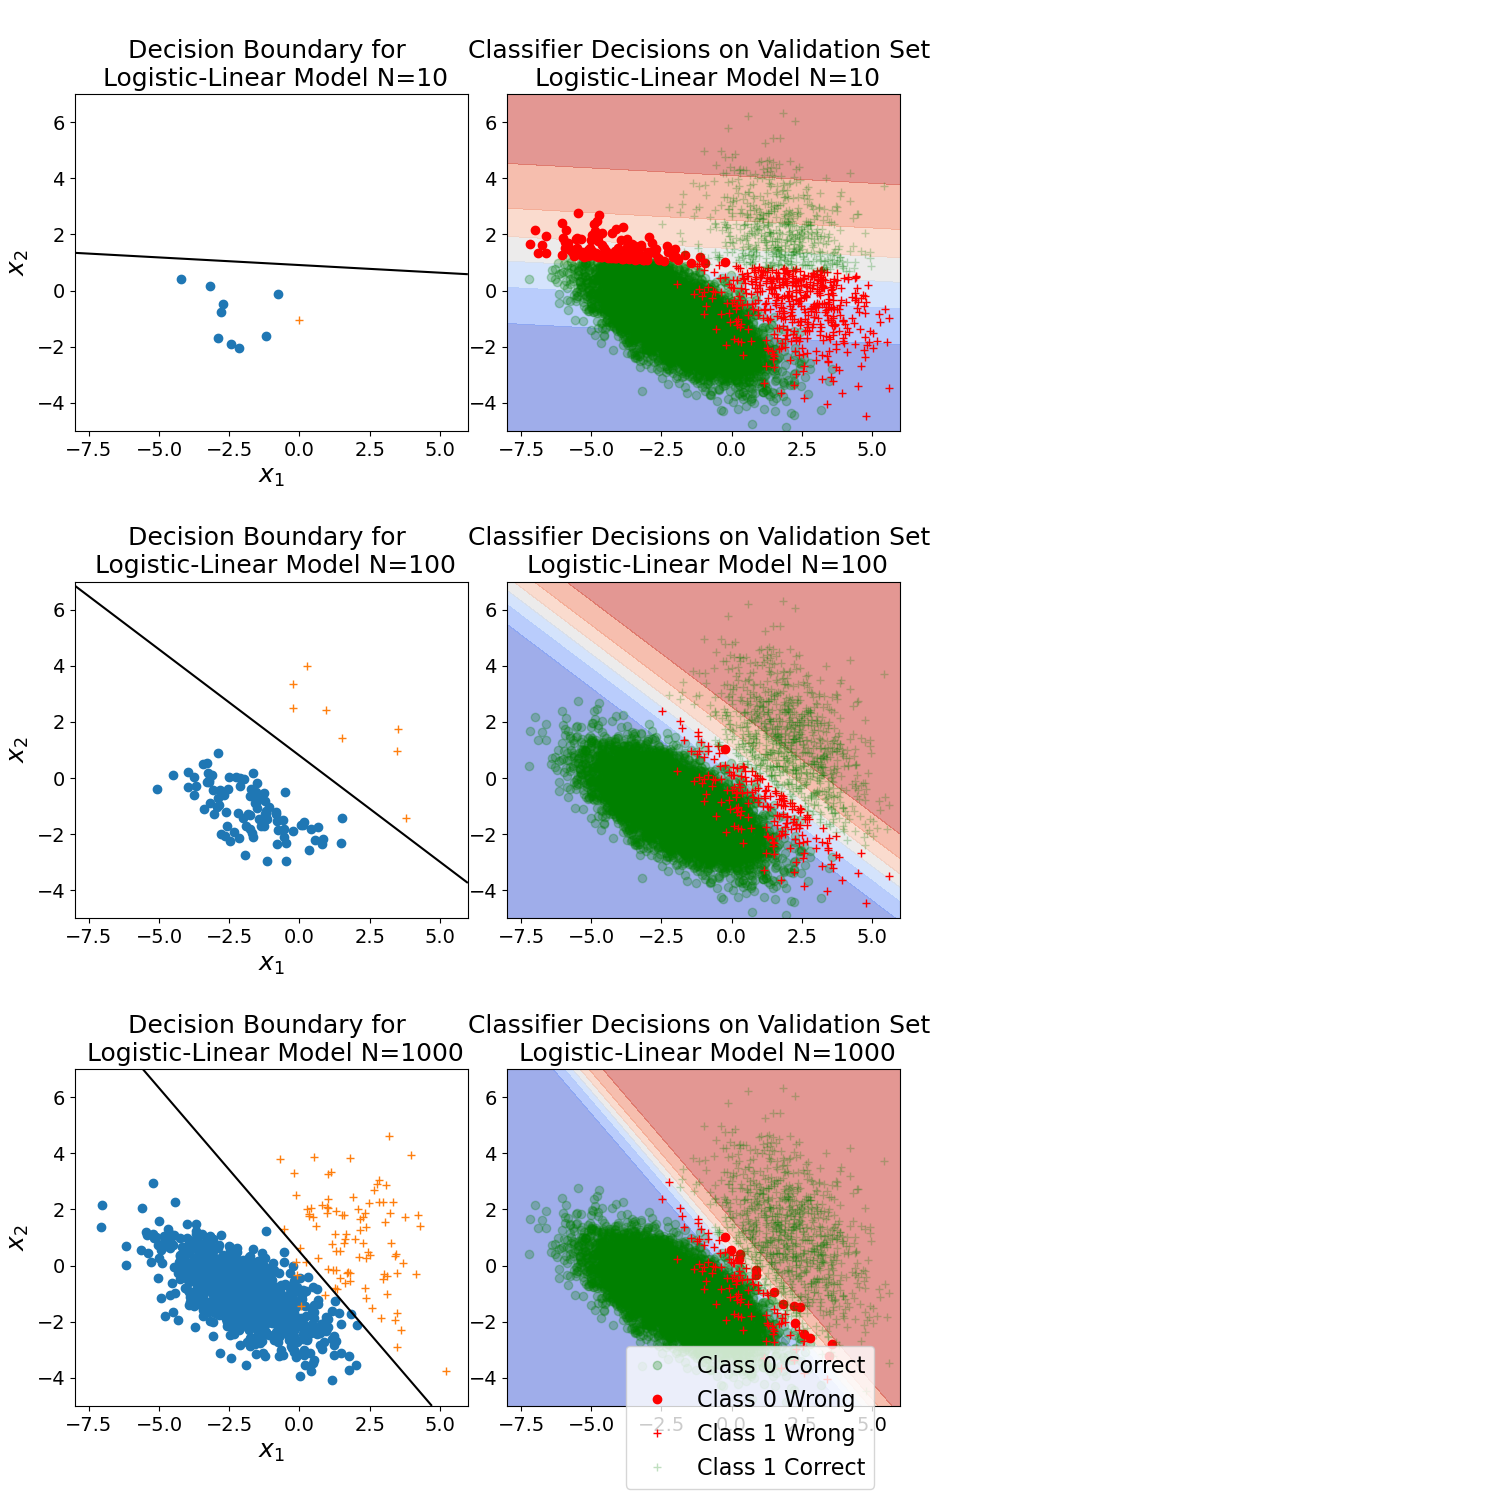

In [9]:
# Starting point from to search for optimal parameters
theta0_linear = np.random.randn(n)

fig_decision, ax_decision = plt.subplots(3, 2, figsize=(15, 15));

print("Training the logistic-linear model with GD per data subset"),
for i in range(len(N_train)):
    shuffled_indices = np.random.permutation(N_train[i]) 
    
    # Shuffle row-wise X (i.e. across training examples) and labels using same permuted order
    X = X_train[i][shuffled_indices]
    y = y_train[i][shuffled_indices]

    theta_gd, trace = gradient_descent(log_reg_loss, theta0_linear, X, y, N_train[i], **opts)

    print("Logistic-Linear N={} GD Theta: {}".format(N_train[i], theta_gd))
    print("Logistic-Linear N={} NLL: {}".format(N_train[i], trace['loss'][-1]))

    # Convert our trace of parameter and loss function values into NumPy "history" arrays:
    theta_hist = np.asarray(trace['theta'])
    nll_hist = np.array(trace['loss'])
    
    plot_decision_boundaries(X, y, theta_gd, ax_decision[i, 0])
    ax_decision[i, 0].set_title("Decision Boundary for \n Logistic-Linear Model N={}".format(X.shape[0]))

    # Linear: use validation data (10k samples) and make decisions in report results routine
    report_logistic_classifier_results(X_valid, theta_gd, y_valid, Ny_valid, ax_decision[i, 1])
    ax_decision[i, 1].set_title("Classifier Decisions on Validation Set \n Logistic-Linear Model N={}".format(N_train[i]))

# Again use the most sampled subset (validation) to define x-y limits
plt.setp(ax_decision, xlim=x1_valid_lim, ylim=x2_valid_lim)

# Adjust subplot positions
plt.subplots_adjust(left=0.05,
                    bottom=0.05, 
                    right=0.6, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.3)

# Super plot the legends
handles, labels = ax_decision[0, 1].get_legend_handles_labels()
fig_decision.legend(handles, labels, loc='lower center')

plt.show()

### Quadratic Case

We can explore the same procedure as above, but instead for a logistic-quadratic regression model. Below walks through the same steps, with minor adjustments to accommodate a quadratic decision boundary. Note this could have been entirely encapsulated into one loop over the training sets.

Training the logistic-quadratic model with GD per data subset
1 batches of size 10

Logistic-Quadratic N=10 GD Theta: [-1.1301644  -0.29109457 -0.56225527 -0.42208809 -0.87293174  0.42045982]
Logistic-Quadratic N=10 NLL: 0.1374837904609503
The total error achieved with this classifier is 0.236
10 batches of size 10

Logistic-Quadratic N=100 GD Theta: [-1.50023838  0.80709739  0.94738721 -0.00300338 -0.13361078  0.06710652]
Logistic-Quadratic N=100 NLL: 0.4172674624572139
The total error achieved with this classifier is 0.023
100 batches of size 10

Logistic-Quadratic N=1000 GD Theta: [-1.09079253  2.20383385  1.78581203  0.09391511  0.00008521 -0.1293701 ]
Logistic-Quadratic N=1000 NLL: 2.3092912277460123
The total error achieved with this classifier is 0.012


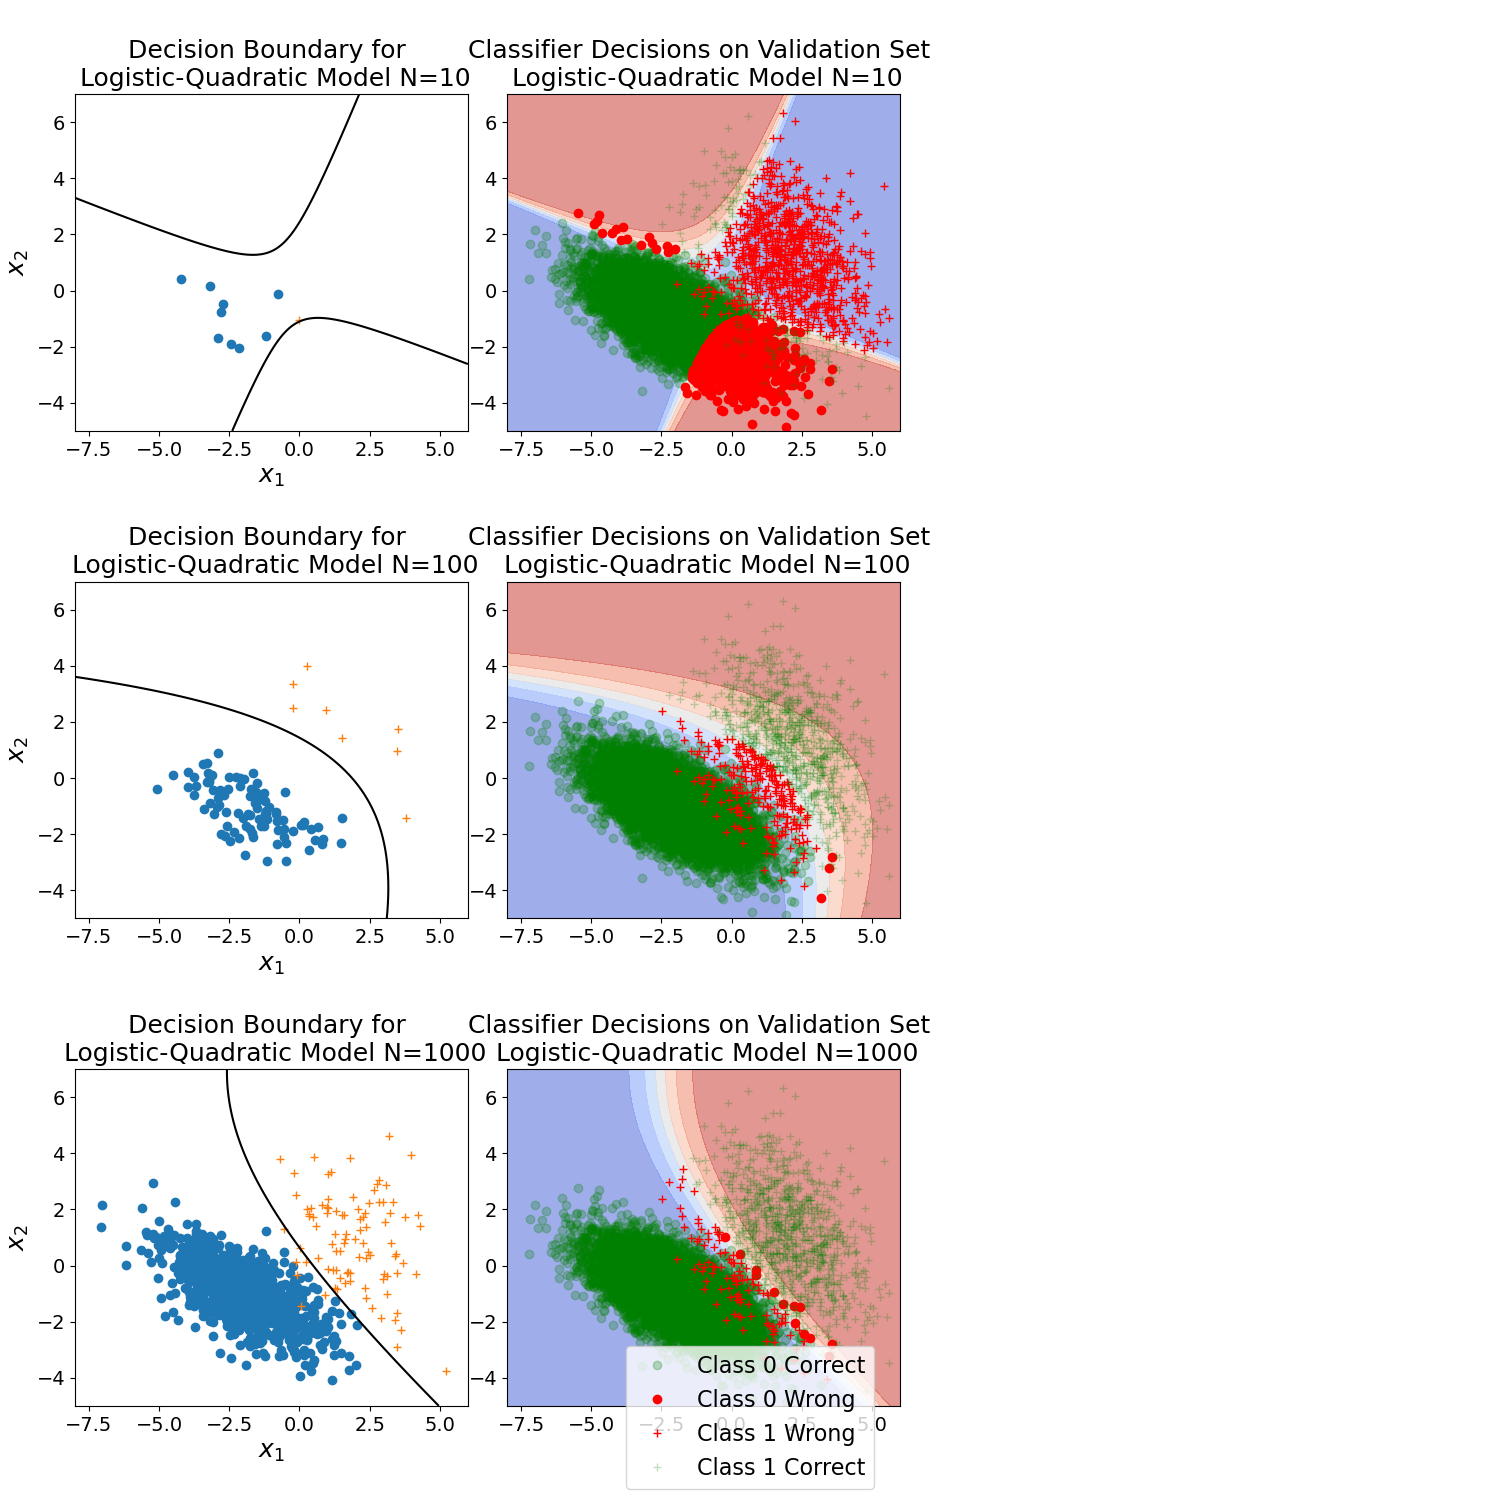

In [10]:
# NOTE that the initial parameters have added dimensionality to match the basis expansion set
theta0_quadratic = np.random.randn(n+3)

fig_decision, ax_decision = plt.subplots(3, 2, figsize=(15, 15));

print("Training the logistic-quadratic model with GD per data subset"),
for i in range(len(N_train)):
    shuffled_indices = np.random.permutation(N_train[i]) 
    
    # Shuffle row-wise X (i.e. across training examples) and labels using same permuted order
    X = X_train[i][shuffled_indices]
    y = y_train[i][shuffled_indices]
    
    # Important transformation line to add monic polynomial terms for a quadratic
    X_quad = quadratic_transformation(X)
    theta_gd, trace = gradient_descent(log_reg_loss, theta0_quadratic, X_quad, y, N_train[i], **opts)

    print("Logistic-Quadratic N={} GD Theta: {}".format(N_train[i], theta_gd))
    print("Logistic-Quadratic N={} NLL: {}".format(N_train[i], trace['loss'][-1]))

    # Convert our trace of parameter and loss function values into NumPy "history" arrays:
    theta_hist = np.asarray(trace['theta'])
    nll_hist = np.array(trace['loss'])
    
    plot_decision_boundaries(X_quad, y, theta_gd, ax_decision[i, 0], poly_type='Q')
    ax_decision[i, 0].set_title("Decision Boundary for \n Logistic-Quadratic Model N={}".format(X.shape[0]))

    # Quadratic: use validation data (10k samples) and make decisions in report results routine
    X_valid_quad = quadratic_transformation(X_valid)
    report_logistic_classifier_results(X_valid_quad, theta_gd, y_valid, Ny_valid, ax_decision[i, 1], poly_type='Q')
    ax_decision[i, 1].set_title("Classifier Decisions on Validation Set \n Logistic-Quadratic Model N={}".format(N_train[i]))


# Again use the most sampled subset (validation) to define x-y limits
plt.setp(ax_decision, xlim=x1_valid_lim, ylim=x2_valid_lim)

# Adjust subplot positions
plt.subplots_adjust(left=0.05,
                    bottom=0.05, 
                    right=0.6, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.3)

# Super plot the legends
handles, labels = ax_decision[0, 1].get_legend_handles_labels()
fig_decision.legend(handles, labels, loc='lower center')

plt.show()

## Second-Order Optimization Alternative

We can also run all of the above using a second-order optimization method from [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html):

In [11]:
from scipy.optimize import minimize
epsilon = 1e-7 # Epsilon; smallest positive floating value

# Binary cross entropy, equiv to NLL in this context
def bce(y, predictions):
    # Epsilon adjustment handles numerical errors by avoiding underflow or overflow
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    # log P(Y=0 | x; theta)
    log_p0 = (1-y) * np.log(1-predictions + epsilon)
    # log P(Y=1 | x; theta)
    log_p1 = y * np.log(predictions + epsilon)
    
    return -np.mean(log_p0 + log_p1, axis=0)


def compute_logistic_params(X, y):
    """
    Calculates the MLE of the parameter theta for the logistic-linear model, and returns it.
    """
    
    # Dimensionality including the addition of bias term
    theta0 = np.random.randn(X.shape[1])

    # Solve the optimization problem
    cost_fun = lambda th: bce(y, predict_prob(X, th))
    res = minimize(cost_fun, theta0, tol=1e-6)
    
    return res.x


plt.ioff()
fig_linear, ax_linear = plt.subplots(3, 2, figsize=(15, 15));
fig_quad, ax_quad = plt.subplots(3, 2, figsize=(15, 15));
plt.ion()

print("Training the logistic models with 2nd order optimization methods per data subset"),
for i in range(len(N_train)):    
    X = X_train[i]
    y = y_train[i]
    
    theta_linear_opt = compute_logistic_params(X, y)
    print("Logistic-Linear N={} Opt Theta: {}".format(N_train[i], theta_linear_opt))
    
    plot_decision_boundaries(X, y, theta_linear_opt, ax_linear[i, 0])
    ax_linear[i, 0].set_title("Decision Boundary for \n Logistic-Linear Model N={}".format(X.shape[0]))
    ax_linear[i, 0].set_xticks([])
    # Linear: use validation data (10k samples) and make decisions in report results routine
    report_logistic_classifier_results(X_valid, theta_linear_opt, y_valid, Ny_valid, ax_linear[i, 1])
    ax_linear[i, 1].set_title("Classifier Decisions on Validation Set \n Logistic-Linear Model N={}".format(N_train[i]))
    ax_linear[i, 1].set_xticks([])

    # Quadratic transformation of inputs
    X_quad = quadratic_transformation(X)
    theta_quad_opt = compute_logistic_params(X_quad, y)
    print("Logistic-Quadratic N={} Opt Theta: {}".format(N_train[i], theta_quad_opt))
    
    plot_decision_boundaries(X_quad, y, theta_quad_opt, ax_quad[i, 0], poly_type='Q')
    ax_quad[i, 0].set_title("Decision Boundary for \n Logistic-Quadratic Model N={}".format(X.shape[0]))
    ax_quad[i, 0].set_xticks([])
    # Quadratic: use validation data (10k samples) and make decisions in report results routine
    X_valid_quad = quadratic_transformation(X_valid)
    report_logistic_classifier_results(X_valid_quad, theta_quad_opt, y_valid, Ny_valid, ax_quad[i, 1], poly_type='Q')
    ax_quad[i, 1].set_title("Classifier Decisions on Validation Set \n Logistic-Quadratic Model N={}".format(N_train[i]))
    ax_quad[i, 1].set_xticks([])

Training the logistic models with 2nd order optimization methods per data subset
Logistic-Linear N=10 Opt Theta: [ 6.28552759 26.82730624 -5.39220315]
The total error achieved with this classifier is 0.151
Logistic-Quadratic N=10 Opt Theta: [  3.57157977  10.63288359  -7.55542889 -12.88740441  -9.85910758
   6.99394627]
The total error achieved with this classifier is 0.261
Logistic-Linear N=100 Opt Theta: [-14.14702236  17.69731523  29.89043271]
The total error achieved with this classifier is 0.017
Logistic-Quadratic N=100 Opt Theta: [-42.05042101  43.54470916 118.01641945  10.52032686  13.37954845
  -8.43932083]
The total error achieved with this classifier is 0.052
Logistic-Linear N=1000 Opt Theta: [-0.32418371  3.96419333  4.00075248]


C:\Users\mark_\AppData\Local\Temp\ipykernel_3952\2560661826.py:3: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-z))


The total error achieved with this classifier is 0.010
Logistic-Quadratic N=1000 Opt Theta: [-0.21174434  5.1593839   4.5805626   0.60625901  1.50044559  0.48405141]
The total error achieved with this classifier is 0.010


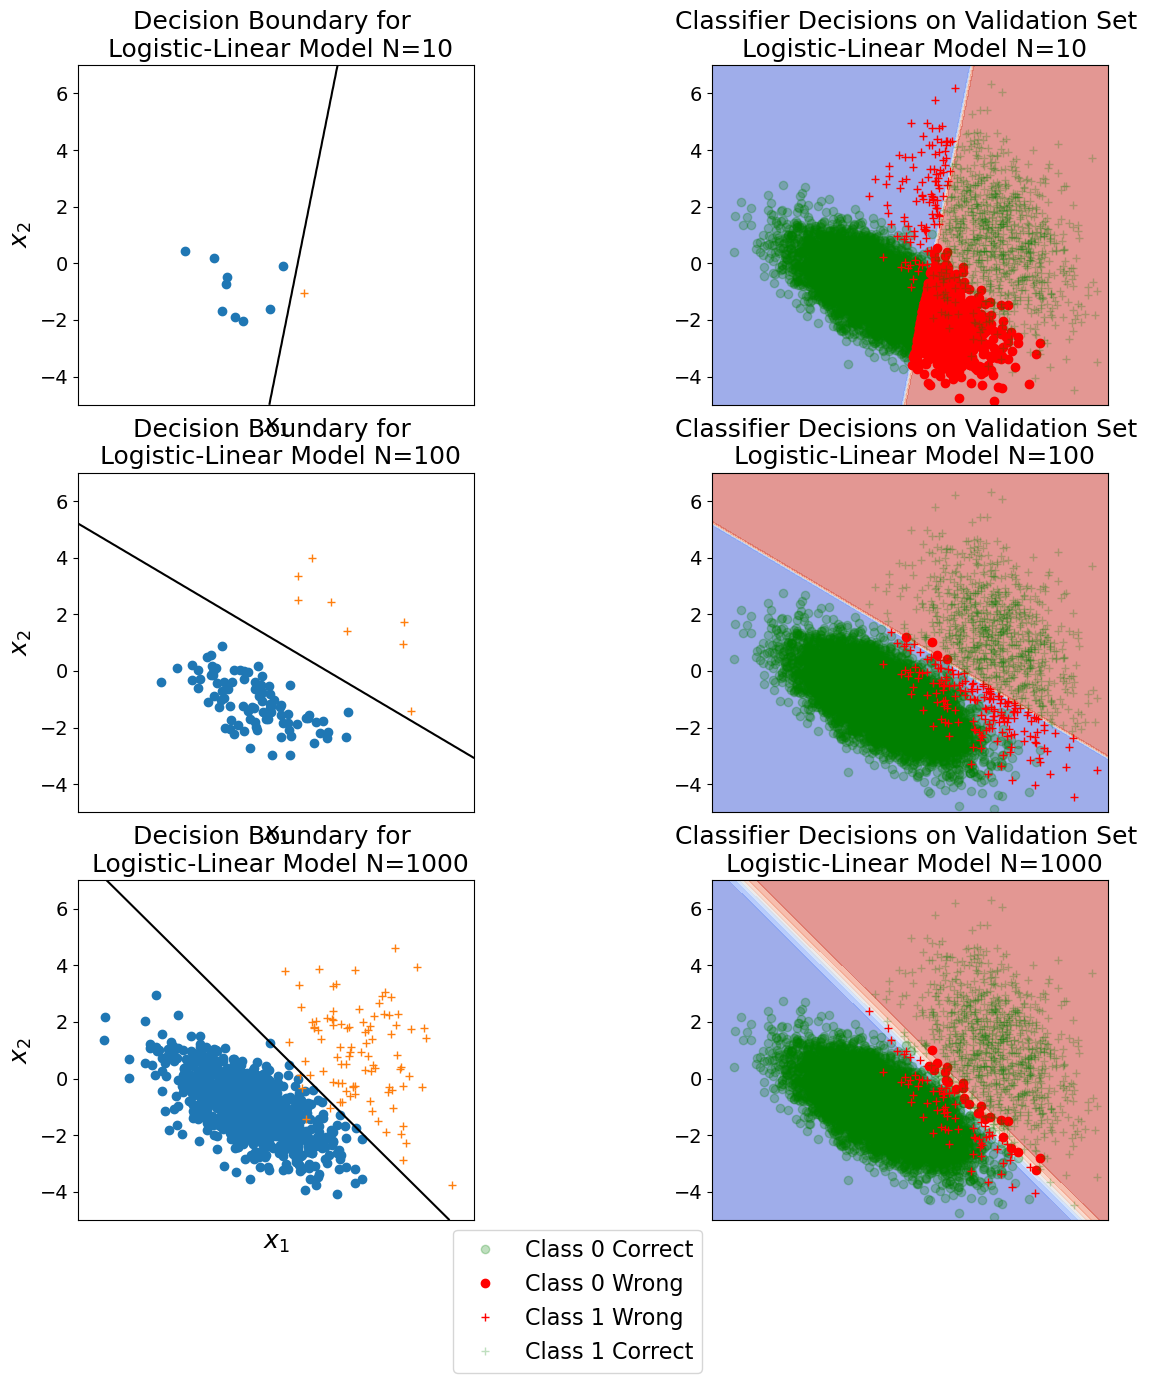

In [12]:
plt.setp(ax_linear, xlim=x1_valid_lim, ylim=x2_valid_lim)

handles, labels = ax_linear[0, 1].get_legend_handles_labels()
fig_linear.legend(handles, labels, loc='lower center')

fig_linear

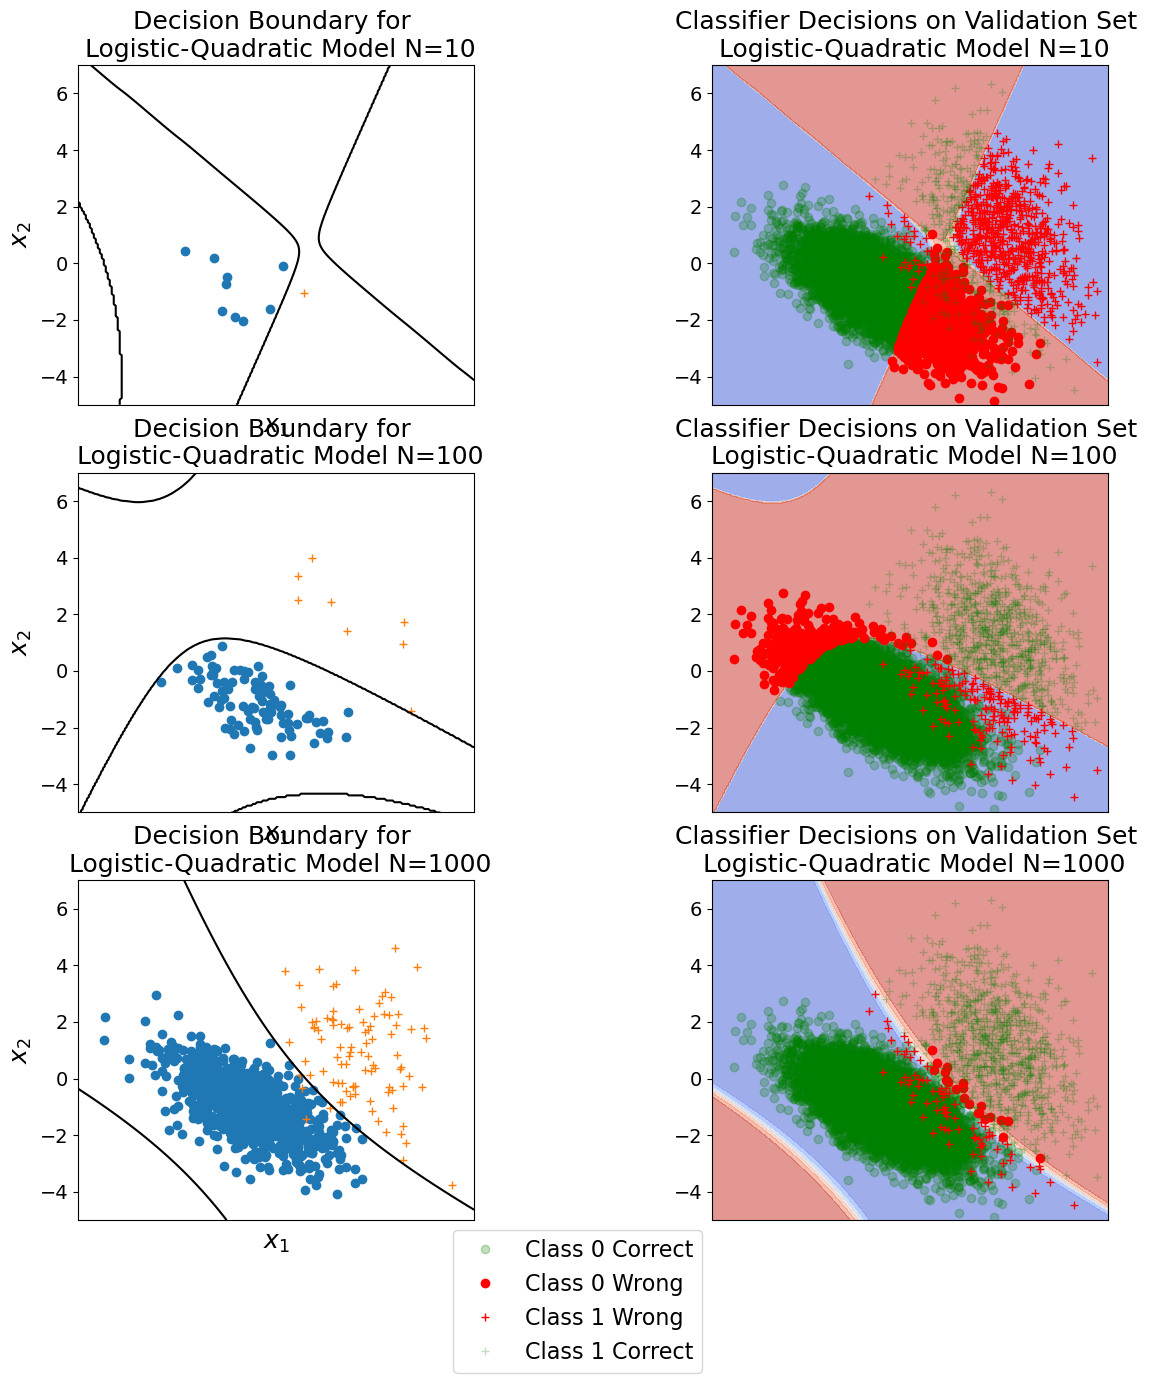

In [13]:
plt.setp(ax_quad, xlim=x1_valid_lim, ylim=x2_valid_lim)

handles, labels = ax_quad[0, 1].get_legend_handles_labels()
fig_quad.legend(handles, labels, loc='lower center')

fig_quad